In [1]:
# testing extended search area piv from pyprocess

In [2]:
import numpy as np
from numpy.fft import rfft2, irfft2, fftshift
from numpy import log
import matplotlib.pyplot as plt
from openpiv import tools

In [3]:

def sig2noise_ratio(corr, sig2noise_method="peak2peak", width=2):
    """
    Computes the signal to noise ratio from the correlation map.

    The signal to noise ratio is computed from the correlation map with
    one of two available method. It is a measure of the quality of the
    matching between to interrogation windows.

    Parameters
    ----------
    corr : 2d np.ndarray
        the correlation map.

    sig2noise_method: string
        the method for evaluating the signal to noise ratio value from
        the correlation map. Can be `peak2peak`, `peak2mean` or None
        if no evaluation should be made.

    width : int, optional
        the half size of the region around the first
        correlation peak to ignore for finding the second
        peak. [default: 2]. Only used if ``sig2noise_method==peak2peak``.

    Returns
    -------
    sig2noise : float
        the signal to noise ratio from the correlation map.

    """

    # compute first peak position
    (peak1_i, peak1_j), corr_max1 = find_first_peak(corr)

    # now compute signal to noise ratio
    if sig2noise_method == "peak2peak":
        # find second peak height
        (peak2_i, peak2_j), corr_max2 = find_second_peak(
            corr, peak1_i, peak1_j, width=width
        )

        # if it's an empty interrogation window
        # if the image is lacking particles, totally black it will correlate
        # to very low value, but not zero
        # if the first peak is on the borders, the correlation map is also
        # wrong
        if corr_max1 < 1e-3 or (
            peak1_i == 0
            or peak1_j == corr.shape[0]
            or peak1_j == 0
            or peak1_j == corr.shape[1]
            or peak2_i == 0
            or peak2_j == corr.shape[0]
            or peak2_j == 0
            or peak2_j == corr.shape[1]
        ):
            # return zero, since we have no signal.
            return 0.0

    elif sig2noise_method == "peak2mean":
        # find mean of the correlation map
        corr_max2 = corr.mean()

    else:
        raise ValueError("wrong sig2noise_method")

    # avoid dividing by zero
    try:
        sig2noise = corr_max1 / corr_max2
    except ValueError:
        sig2noise = np.inf

    return sig2noise


In [4]:

def find_second_peak(corr, i=None, j=None, width=2):
    """
    Find the value of the second largest peak.

    The second largest peak is the height of the peak in
    the region outside a 3x3 submatrxi around the first
    correlation peak.

    Parameters
    ----------
    corr: np.ndarray
          the correlation map.

    i,j : ints
          row and column location of the first peak.

    width : int
        the half size of the region around the first correlation
        peak to ignore for finding the second peak.

    Returns
    -------
    i : int
        the row index of the second correlation peak.

    j : int
        the column index of the second correlation peak.

    corr_max2 : int
        the value of the second correlation peak.

    """

    if i is None or j is None:
        i, j, tmp = find_first_peak(corr)

    # create a masked view of the corr
    tmp = corr.view(ma.MaskedArray)

    # set width x width square submatrix around the first correlation peak as
    # masked.
    # Before check if we are not too close to the boundaries, otherwise we
    # have negative indices
    iini = max(0, i - width)
    ifin = min(i + width + 1, corr.shape[0])
    jini = max(0, j - width)
    jfin = min(j + width + 1, corr.shape[1])
    tmp[iini:ifin, jini:jfin] = ma.masked
    i, j, corr_max2 = find_first_peak(tmp)

    return i, j, corr_max2


In [5]:

def find_first_peak(corr):
    """
    Find row and column indices of the first correlation peak.

    Parameters
    ----------
    corr : np.ndarray
        the correlation map

    Returns
    -------

    """

    return np.unravel_index(np.argmax(corr), corr.shape), corr.max()

In [6]:

def fft_correlate(window_a, window_b):
    """ FFT based cross correlation
    it is a so-called linear convolution based,
    since we increase the size of the FFT to
    reduce the edge effects.

    This should also work out of the box for rectangular windows.

    Parameters
    ----------
    window_a : 2d np.ndarray
        a two dimensions array for the first interrogation window,

    window_b : 2d np.ndarray
        a two dimensions array for the second interrogation window.

    # from Stackoverflow:
    from scipy import linalg
    import numpy as np

    # works for rectangular windows as well

    x = [[1 , 0 , 0 , 0] , [0 , -1 , 0 , 0] , [0 , 0 , 3 , 0] ,
        [0 , 0 , 0 , 1], [0 , 0 , 0 , 1]]
    x = np.array(x,dtype=np.float)
    y = [[4 , 5] , [3 , 4]]
    y = np.array(y)
    print ("conv:" ,  signal.convolve2d(x , y , 'full'))
    s1 = np.array(x.shape)
    s2 = np.array(y.shape)
    size = s1 + s2 - 1
    fsize = 2 ** np.ceil(np.log2(size)).astype(int)
    fslice = tuple([slice(0, int(sz)) for sz in size])
    new_x = np.fft.fft2(x , fsize)
    new_y = np.fft.fft2(y , fsize)
    result = np.fft.ifft2(new_x*new_y)[fslice].copy()
    print("fft for my method:" , np.array(result.real, np.int32))
    """
    s1 = np.array(window_a.shape)
    s2 = np.array(window_b.shape)
    size = s1 + s2 - 1
    fsize = 2 ** np.ceil(np.log2(size)).astype(int)
    fslice = tuple([slice(0, int(sz)) for sz in size])
    f2a = rfft2(window_a, fsize)
    f2b = rfft2(window_b[::-1, ::-1], fsize)
    corr = irfft2(f2a * f2b).real[fslice]
    return corr

In [7]:
def correlate_windows(window_a, window_b, correlation_method="fft"):
    """Compute correlation function between two interrogation windows.

    The correlation function can be computed by using the correlation
    theorem to speed up the computation.

    Parameters
    ----------
    window_a : 2d np.ndarray
        a two dimensions array for the first interrogation window,

    window_b : 2d np.ndarray
        a two dimensions array for the second interrogation window.

    correlation_method : string, methods currently implemented:
            'circular' - FFT based without zero-padding
            'linear' -  FFT based with zero-padding
            'direct' -  linear convolution based
            Default is 'fft', which is much faster.

    Returns
    -------
    corr : 2d np.ndarray
        a two dimensions array for the correlation function.

    Note that due to the wish to use 2^N windows for faster FFT
    we use a slightly different convention for the size of the
    correlation map. The theory says it is M+N-1, and the
    'direct' method gets this size out
    the FFT-based method returns M+N size out, where M is the window_size
    and N is the search_area_size
    It leads to inconsistency of the output
    """

    # first we remove the mean to normalize contrast and intensity
    # the background level which is take as a mean of the image
    # is subtracted
    # import pdb; pdb.set_trace()
    window_a = normalize_intensity(window_a)
    window_b = normalize_intensity(window_b)

    # this is not really circular one, as we pad a bit to get fast 2D FFT,
    # see fft_correlate for implementation
    if correlation_method in ("circular", "fft"):
        corr = fft_correlate(window_a, window_b)
    elif correlation_method == "linear":
        # save the original size:
        s1 = np.array(window_a.shape)
        s2 = np.array(window_b.shape)
        size = s1 + s2 - 1
        fslice = tuple([slice(0, int(sz)) for sz in size])
        # and slice only the relevant part
        corr = fft_correlate(zero_pad(window_a), zero_pad(window_b))[fslice]
    elif correlation_method == "direct":
        corr = convolve2d(window_a, window_b[::-1, ::-1], "full")
    else:
        raise ValueError("method is not implemented")

    return corr

In [8]:
def normalize_intensity(window):
    """Normalize interrogation window or strided image of many windows,
       by removing the mean intensity value per window and clipping the
       negative values to zero

    Parameters
    ----------
    window :  2d np.ndarray
        the interrogation window array

    Returns
    -------
    window :  2d np.ndarray
        the interrogation window array, with mean value equal to zero.

    """
    window = window.astype(np.float32)
    window = window - window.mean(axis=(-2, -1), keepdims=True, dtype=np.float32)
    window = window/(1.96*np.std(window, dtype=np.float32))
    return np.clip(window, -1, 1)

In [9]:
def fft_correlate_strided_images(image_a, image_b):
    """ FFT based cross correlation
    of two images with multiple views of np.stride_tricks()
    
    The 2D FFT should be applied to the last two axes (-2,-1) and the
    zero axis is the number of the interrogation window

    This should also work out of the box for rectangular windows.

    Parameters
    ----------
    image_a : 3d np.ndarray, first dimension is the number of windows,
        and two last dimensions are interrogation windows of the first image
    image_b : similar
    """
    s1 = np.array(image_a.shape[-2:])
    s2 = np.array(image_b.shape[-2:])
    size = s1 + s2 - 1
    fsize = 2 ** np.ceil(np.log2(size)).astype(int)
    fslice = tuple([slice(0, image_a.shape[0])] + \
                   [slice(0, int(sz)) for sz in size])
    f2a = rfft2(image_a, fsize, axes=(-2, -1))
    f2b = rfft2(image_b[:,::-1, ::-1], fsize, axes=(-2, -1))
    corr = irfft2(f2a * f2b, axes=(-2,-1)).real[fslice]
    return corr

In [10]:
def find_subpixel_peak_position(corr, subpixel_method="gaussian"):
    """
    Find subpixel approximation of the correlation peak.

    This function returns a subpixels approximation of the correlation
    peak by using one of the several methods available. If requested,
    the function also returns the signal to noise ratio level evaluated
    from the correlation map.

    Parameters
    ----------
    corr : np.ndarray
        the correlation map.

    subpixel_method : string
         one of the following methods to estimate subpixel location of the
         peak:
         'centroid' [replaces default if correlation map is negative],
         'gaussian' [default if correlation map is positive],
         'parabolic'.

    Returns
    -------
    subp_peak_position : two elements tuple
        the fractional row and column indices for the sub-pixel
        approximation of the correlation peak.
    """

    # initialization
    # default_peak_position = (np.floor(corr.shape[0] / 2.),
    # np.floor(corr.shape[1] / 2.))
    # default_peak_position = np.array([0,0])
    
    subp_peak_position = np.zeros((1,2))
    
    # check inputs
    if subpixel_method not in ('gaussian', 'centroid', 'parabolic'):
        raise ValueError(f'Method not implemented {subpixel_method}')

    # the peak locations
    (peak1_i, peak1_j), dummy = find_first_peak(corr)
    
    # import pdb; pdb.set_trace()

#   try:
    # the peak and its neighbours: left, right, down, up
    c = corr[peak1_i, peak1_j]
    cl = corr[peak1_i - 1, peak1_j]
    cr = corr[peak1_i + 1, peak1_j]
    cd = corr[peak1_i, peak1_j - 1]
    cu = corr[peak1_i, peak1_j + 1]

    # gaussian fit
    if (
        np.any(np.array([c, cl, cr, cd, cu]) < 0)
        and subpixel_method == "gaussian"
    ):
        subpixel_method = "centroid"

    # try:
    if subpixel_method == "centroid":
        subp_peak_position = (
            ((peak1_i - 1) * cl + peak1_i * c + (peak1_i + 1) * cr)
            / (cl + c + cr),
            ((peak1_j - 1) * cd + peak1_j * c + (peak1_j + 1) * cu)
            / (cd + c + cu),
        )

    elif subpixel_method == "gaussian":
        subp_peak_position = (
            peak1_i
            + (
                (log(cl) - log(cr))
                / (2 * log(cl) - 4 * log(c) + 2 * log(cr))
            ),
            peak1_j
            + (
                (log(cd) - log(cu))
                / (2 * log(cd) - 4 * log(c) + 2 * log(cu))
            ),
        )

    elif subpixel_method == "parabolic":
        subp_peak_position = (
            peak1_i + (cl - cr) / (2 * cl - 4 * c + 2 * cr),
            peak1_j + (cd - cu) / (2 * cd - 4 * c + 2 * cu),
        )

#     except BaseException:
#         subp_peak_position = default_peak_position

#     except IndexError:
#         subp_peak_position = default_peak_position

    return subp_peak_position

In [11]:
def get_field_shape(image_size, search_area_size, window_size, overlap):
    """Compute the shape of the resulting flow field.

    Given the image size, the interrogation window size and
    the overlap size, it is possible to calculate the number
    of rows and columns of the resulting flow field.

    Parameters
    ----------
    image_size: two elements tuple
        a two dimensional tuple for the pixel size of the image
        first element is number of rows, second element is
        the number of columns, easy to obtain using .shape

    search_area_size: tuple
        the size of the search area window.

    window_size: tuple
        the size of the interrogation window.

    overlap: tuple
        the number of pixel by which two adjacent interrogation
        windows overlap.


    Returns
    -------
    field_shape : three elements tuple
        the shape of the resulting flow field
    """
    field_shape = (np.array(image_size) - np.array(search_area_size)) // \
                  (np.array(window_size) - np.array(overlap)) + 1
    return field_shape

In [12]:
frame_a = tools.imread('../test1/exp1_001_a.bmp')
frame_b = tools.imread('../test1/exp1_001_b.bmp')

In [13]:
#frame_a = frame_a[:64,:64]
# frame_b = frame_b[:64,:64]

In [14]:
def show_pair(I,J):
    fig, ax = plt.subplots(1,2,figsize=(12,8))
    ax[0].imshow(I,cmap=plt.cm.gray)
    ax[1].imshow(J,cmap=plt.cm.gray)

In [15]:
%%time
# def extended_search_area_piv(
window_size = 32
overlap = 16
dt=1.0
search_area_size = 32
correlation_method="fft"
subpixel_method="gaussian"
sig2noise_method='peak2mean'
width = 2
nfftx = 0
nffty = 0
# ):
#     """Standard PIV cross-correlation algorithm, with an option for
#     extended area search that increased dynamic range. The search region
#     in the second frame is larger than the interrogation window size in the
#     first frame. For Cython implementation see
#     openpiv.process.extended_search_area_piv

#     This is a pure python implementation of the standard PIV cross-correlation
#     algorithm. It is a zero order displacement predictor, and no iterative
#     process is performed.

#     Parameters
#     ----------
#     frame_a : 2d np.ndarray
#         an two dimensions array of integers containing grey levels of
#         the first frame.

#     frame_b : 2d np.ndarray
#         an two dimensions array of integers containing grey levels of
#         the second frame.

#     window_size : int
#         the size of the (square) interrogation window, [default: 32 pix].

#     overlap : int
#         the number of pixels by which two adjacent windows overlap
#         [default: 16 pix].

#     dt : float
#         the time delay separating the two frames [default: 1.0].

#     correlation_method : string
#         one of the two methods implemented: 'fft' or 'direct',
#         [default: 'fft'].

#     subpixel_method : string
#          one of the following methods to estimate subpixel location of the
#          peak:
#          'centroid' [replaces default if correlation map is negative],
#          'gaussian' [default if correlation map is positive],
#          'parabolic'.

#     sig2noise_method : string
#         defines the method of signal-to-noise-ratio measure,
#         ('peak2peak' or 'peak2mean'. If None, no measure is performed.)

#     nfftx   : int
#         the size of the 2D FFT in x-direction,
#         [default: 2 x windows_a.shape[0] is recommended]

#     nffty   : int
#         the size of the 2D FFT in y-direction,
#         [default: 2 x windows_a.shape[1] is recommended]

#     width : int
#         the half size of the region around the first
#         correlation peak to ignore for finding the second
#         peak. [default: 2]. Only used if ``sig2noise_method==peak2peak``.

#     search_area_size : int
#        the size of the interrogation window in the second frame,
#        default is the same interrogation window size and it is a
#        fallback to the simplest FFT based PIV


#     Returns
#     -------
#     u : 2d np.ndarray
#         a two dimensional array containing the u velocity component,
#         in pixels/seconds.

#     v : 2d np.ndarray
#         a two dimensional array containing the v velocity component,
#         in pixels/seconds.

#     sig2noise : 2d np.ndarray, ( optional: only if sig2noise_method != None )
#         a two dimensional array the signal to noise ratio for each
#         window pair.

#     """

# check the inputs for validity
if search_area_size == 0:
    search_area_size = window_size

if overlap >= window_size:
    raise ValueError("Overlap has to be smaller than the window_size")

if search_area_size < window_size:
    raise ValueError("Search size cannot be smaller than the window_size")

if (window_size > frame_a.shape[0]) or (window_size > frame_a.shape[1]):
    raise ValueError("window size cannot be larger than the image")

# get field shape
n_rows, n_cols = get_field_shape(
    frame_a.shape, search_area_size, window_size, overlap
)

# create empty arrays for deformation in x and y direction
u, v = np.zeros((n_rows, n_cols)), np.zeros((n_rows, n_cols))

# if we want sig2noise information, allocate memory
if sig2noise_method is not None:
    sig2noise = np.zeros((n_rows, n_cols))

# shift for x and y coordinates of the search area windows so that the
# centers of search area windows have
# the same distances to the image edge at all sides. For simplicity only
# shifts by integers are allowed
x_centering = (
    frame_a.shape[1] - 1
    - ((n_cols - 1) * (window_size - overlap) + (search_area_size - 1))
) // 2
y_centering = (
    frame_a.shape[0] - 1
    - ((n_rows - 1) * (window_size - overlap) + (search_area_size - 1))
) // 2

# iterate through interrogation widows and search areas
for k in range(n_rows):
    for m in range(n_cols):

        # centers of search area. (window_size - overlap) defines the
        # distance between each center
        # and (search_area_size - 1)/2.0 moves the center points away from
        # the left or top image edge
        y = k * (window_size - overlap) + (search_area_size - 1) / 2.0
        x = m * (window_size - overlap) + (search_area_size - 1) / 2.0

        # moving the coordinates a bit to the center, to guarantee that
        # the distance
        #  of a extreme point at the image edges is symmetric all all edges
        x += x_centering
        y += y_centering

        # left, right, top, bottom indices of the search area edges
        # note that x - (search_area_size +/- 1)/2  always returns an
        # integer due to the definition of x and y
        # see also "get_coordinates()"
        il = int(y - (search_area_size - 1) / 2.0)
        ir = int(y + (search_area_size + 1) / 2.0)
        it = int(x - (search_area_size - 1) / 2.0)
        ib = int(x + (search_area_size + 1) / 2.0)
        # picking the search area from frame b
        window_b = frame_b[il:ir, it:ib]

        # left, right, top, bottom indices of the interrogation window
        # Sometimes the interrogation window cannot be placed in the
        # middle of the search area, e.g.
        # in the case of window_size=3 search_area_size=4. In this case
        # the interrogation window
        # is shifted 0.5 pixels to the left/top, which is achieved by
        # rounding
        # the indices down during the int() conversion
        il = int(y - (window_size - 1) / 2)
        ir = int(y + (window_size + 1) / 2)
        it = int(x - (window_size - 1) / 2)
        ib = int(x + (window_size + 1) / 2)
        # picking the interrogation window from frame a
        window_a = frame_a[il:ir, it:ib]

        if np.any(window_a):
            corr = correlate_windows(
                window_a,
                window_b,
                correlation_method=correlation_method
            )
            # show_pair(window_a, window_b)
            #                 plt.figure()
            #                 plt.contourf(corr)
            #                 plt.show()
            # get subpixel approximation for peak position row and column
            # index
            row, col = find_subpixel_peak_position(
                corr, subpixel_method=subpixel_method
            )

            row -= (search_area_size + window_size - 1) // 2
            col -= (search_area_size + window_size - 1) // 2

            # get displacements, apply coordinate system definition
            u[k, m], v[k, m] = -col, row

            # get signal to noise ratio
            if sig2noise_method is not None:
                sig2noise[k, m] = sig2noise_ratio(
                    corr, sig2noise_method=sig2noise_method, width=width
                )

# return output depending if user wanted sig2noise information
# if sig2noise_method is not None:
#     return u / dt, v / dt, sig2noise
# else:
#     return u / dt, v / dt

CPU times: user 389 ms, sys: 551 µs, total: 390 ms
Wall time: 389 ms


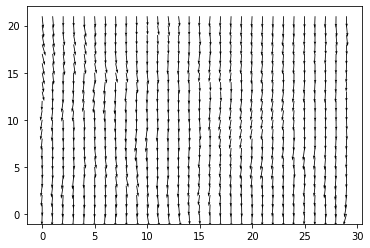

In [16]:
plt.quiver(u,v,scale=150)

In [17]:
n_rows, n_cols

(22, 30)

In [18]:
from openpiv.pyprocess import moving_window_array

In [19]:
%%time
aa = moving_window_array(normalize_intensity(frame_a), window_size, overlap)
bb = moving_window_array(normalize_intensity(frame_b), window_size, overlap)
c = fft_correlate_strided_images(aa,bb)

# iterate through interrogation widows and search areas
u1 = np.zeros((n_rows, n_cols))
v1 = np.zeros((n_rows, n_cols))
for k in range(n_rows):
    for m in range(n_cols):
        row, col = find_subpixel_peak_position(
            c[k*n_rows+m,:,:], subpixel_method=subpixel_method
        )

        row -= (search_area_size + window_size - 1) // 2
        col -= (search_area_size + window_size - 1) // 2

        # get displacements, apply coordinate system definition
        u1[k, m], v1[k, m] = -col, row

CPU times: user 121 ms, sys: 22.8 ms, total: 144 ms
Wall time: 143 ms


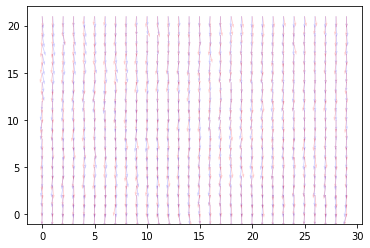

In [20]:
plt.quiver(u,v,scale=150,color='b',alpha=0.2)
plt.quiver(u1,v1,scale=150,color='r',alpha=0.2)